In [2]:
%pylab inline
import numpy as np
from sklearn.linear_model import Ridge
import cv2
from tqdm import tqdm

import torch
import torch.utils.data.dataloader as dataloader
from torchvision import transforms
from torchvision.datasets import MNIST, CIFAR10

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

import pickle

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)


Populating the interactive namespace from numpy and matplotlib


(7, 7)
(28, 28, 3)


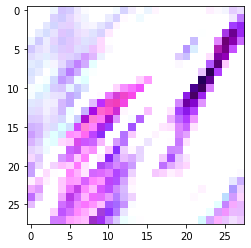

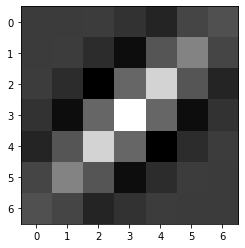

In [2]:
# cv2.getGaborKernel(ksize, sigma, theta, lambda, gamma, psi, ktype)
# ksize - size of gabor filter (n, n)
# sigma - standard deviation of the gaussian function
# theta - orientation of the normal to the parallel stripes
# lambda - wavelength of the sunusoidal factor
# gamma - spatial aspect ratio
# psi - phase offset
# ktype - type and range of values that each pixel in the gabor kernel can hold

k = 7
g_kernel = cv2.getGaborKernel((k, k), k/7.0, 1*np.pi/4, k/2.0, 0.5, 0, ktype=cv2.CV_32F)
print(g_kernel.shape)

# img = cv2.imread('data/Lenna.png', 0)
img = cv2.imread('data/Lenna.png')
img = cv2.resize(img, (28, 28), interpolation=cv2.INTER_CUBIC)
filtered_img = cv2.filter2D(img, cv2.CV_8UC3, g_kernel)

# plt.imshow(img, cmap='gray')
# plt.show()
print(filtered_img.shape)
# plt.imshow(filtered_img, cmap='gray') #'filtered image'
plt.imshow(filtered_img)
plt.show()

h, w = g_kernel.shape[:2]
# g_kernel = cv2.resize(g_kernel, (3*w, 3*h), interpolation=cv2.INTER_CUBIC)
plt.imshow(g_kernel, cmap='gray') #'gabor kernel (resized)'
plt.show()

In [4]:
# load MNIST data
cuda = torch.cuda.is_available()

train = MNIST('./data', train=True, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

p = train.train_data[0].numpy().shape[0]
print(p)

test = MNIST('./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(), # ToTensor does min-max normalization. 
]), )

# Create DataLoader
dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args)
test_loader = dataloader.DataLoader(test, **dataloader_args)

28


In [18]:
len(train.train_data)

60000

## regression on filtered image

In [3]:
# generate gabor filters
n_theta = 4
n_psi = 2
Theta = [i * np.pi /n_theta for i in range(n_theta)]
Psi = [i * np.pi /n_psi for i in range(n_psi)]
ksize = [3, 7, 15]
# ksize = [5, 7, 17]
rep_ct = [int(ceil(p/i)) for i in ksize]
print('\n', Theta, '\n', Psi, '\n', rep_ct)


g_kernels = []
for k in ksize:
    for _theta in Theta:
        for _psi in Psi:
            g_kernel = cv2.getGaborKernel((k, k), k/2.0, _theta, k/2.0,
                                          0.5, _psi, ktype=cv2.CV_32F)        
            g_kernels.append(g_kernel)
                
print(len(g_kernels))


 [0.0, 0.7853981633974483, 1.5707963267948966, 2.356194490192345] 
 [0.0, 1.5707963267948966] 
 [10, 4, 2]
24


100%|██████████| 5000/5000 [00:02<00:00, 1767.77it/s]
(5000, 18816) (5000, 784)
(784, 18816)


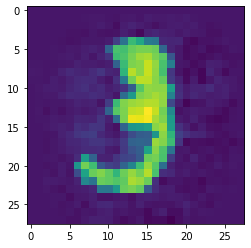

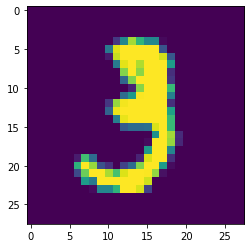

676.6555335649921


In [13]:
# ridge regression to get weights
from sklearn.linear_model import Ridge

all_wts = []
num_sample = 5000 #len(train.data)

y = train.data[:num_sample].numpy()
y = y.reshape(y.shape[0], -1)

X = []
with tqdm(total=num_sample, file=sys.stdout) as pbar:
    for i in range(num_sample):
        img = train.data[i].numpy()
        tmp = []
        for g_kernel in g_kernels:
            tmp.append(cv2.filter2D(img, cv2.CV_8UC3, g_kernel).flatten())
        X.append(np.concatenate(tmp))
        pbar.update(1)

X = np.stack(X)
print(X.shape, y.shape)

clf = Ridge(alpha=0.1)
clf.fit(X, y)

wts = clf.coef_
print(wts.shape)

plt.imshow(X.dot(wts.T)[10].reshape(p, p))
plt.show()
plt.imshow(y[10].reshape(p, p))
plt.show()
print(np.linalg.norm(y[0] - X.dot(wts.T)[0]))

np.save('cache/gabor_wts.npy', wts)

In [16]:
all_wts = np.load('cache/gabor_wts.npy').T
print(all_wts.shape)
from sklearn.decomposition import PCA
num_pc = 450
pca = PCA(n_components=num_pc)
principalComponents = pca.fit_transform(all_wts)
print(pca.explained_variance_ratio_.sum())
print(principalComponents.shape)
print(pca.components_.shape)

(18816, 784)
0.9640751609483953
(18816, 450)
(450, 784)


100%|██████████| 450/450 [00:01<00:00, 369.39it/s]
(100000, 28, 28)
--Return--
> <ipython-input-21-f38fd950398b>(17)<module>()->None
-> import pdb; pdb.set_trace()
(Pdb) plt.imshow(noise[0])
(Pdb) plt.show()


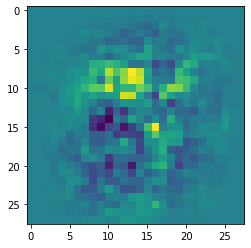

(Pdb) q


BdbQuit: 

In [21]:
num_noise = 100000
noise_wts = np.random.rand(num_noise, num_pc)

with tqdm(total=num_pc, file=sys.stdout) as pbar:
    for i in range(num_pc):
        cur_max = pca.components_[i].max()
        cur_min = pca.components_[i].min()
        cur_wts = noise_wts[:, i]
        cur_wts = (cur_wts - cur_wts.min())/(cur_wts.max() - cur_wts.min())
        noise_wts[:, i] = cur_wts * (cur_max - cur_min) + cur_min
    
        pbar.update(1)

noise = (noise_wts.dot(principalComponents.T)).dot(all_wts)
noise = noise.reshape(num_noise, p, p)
print(noise.shape)
import pdb; pdb.set_trace()
np.save('cache/gabor_noise.npy', noise)

## regression on wavelets

In [5]:
# generate gabor filters
n_theta = 4
n_psi = 2
Theta = [i * np.pi /n_theta for i in range(n_theta)]
Psi = [i * np.pi /n_psi for i in range(n_psi)]
ksize = [3, 7, 15]
# ksize = [5, 15, 29]
rep_ct = [int(ceil(p/i)) for i in ksize]
print('\n', Theta, '\n', Psi, '\n', rep_ct)


g_kernels = []
for i in range(len(rep_ct)):
    for _theta in Theta:
        for _psi in Psi:
            for rep in range(rep_ct[i]**2):
                k = ksize[i]
                g_kernel = cv2.getGaborKernel((k, k), k/7.0, _theta, k/2.0,
                                              0.5, _psi, ktype=cv2.CV_32F) 
                g_kernel = (g_kernel - g_kernel.min())/(g_kernel.max()-g_kernel.min())
                g_kernels.append(g_kernel)
                
print(len(g_kernels))

img_kernels = []
ctr = 0
for idx in range(len(rep_ct)):
    cur_ct = rep_ct[idx]
    k = ksize[idx]
    print(ctr, cur_ct, k)
    for _ in range(n_theta * n_psi):
        with tqdm(total=cur_ct**2, file=sys.stdout) as pbar:
            for i in range(cur_ct):
                for j in range(cur_ct):
#                     import pdb;pdb.set_trace()
                    tmp = np.zeros((p, p))
                    size_i = min(k*(i+1), p) - k*i
                    size_j = min(k*(j+1), p) - k*j
                    tmp[k*i: k*i + size_i, k*j: k*j + size_j] = g_kernels[ctr][:size_i, :size_j]
                    img_kernels.append(tmp)
                    ctr += 1
                    pbar.update(1)
            
        


 [0.0, 0.7853981633974483, 1.5707963267948966, 2.356194490192345] 
 [0.0, 1.5707963267948966] 
 [10, 4, 2]
960
0 10 3
100%|██████████| 100/100 [00:00<00:00, 75315.21it/s]
800 4 7
100%|██████████| 16/16 [00:00<00:00, 17291.64it/s]
928 2 15
100%|██████████| 4/4 [00:00<00:00, 9703.42it/s]


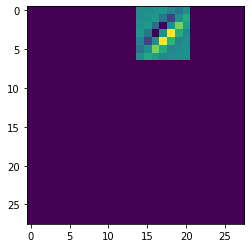

In [15]:
len(img_kernels)
plt.imshow(img_kernels[850])
plt.show()

(784, 960) (784, 60000)
(60000, 960)


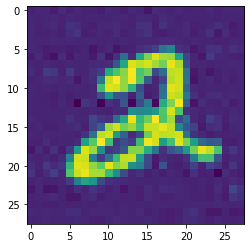

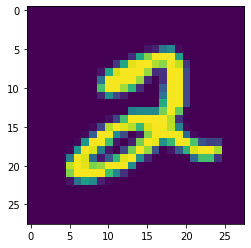

2010.9444903176893


In [5]:
# ridge regression to get weights
from sklearn.linear_model import Ridge

all_wts = []
num_sample = len(train.train_data)

X = np.stack(img_kernels, -1)
X = X.reshape(-1, X.shape[-1])

y = train.train_data[:num_sample].permute(1, 2, 0).numpy()
y = y.reshape(-1, y.shape[-1])

print(X.shape, y.shape)

clf = Ridge(alpha=0.1)
clf.fit(X, y)

wts = clf.coef_
print(wts.shape)
# import pdb; pdb.set_trace()

img_id = 5
plt.imshow(wts.dot(X.T)[img_id].reshape(p, p))
plt.show()
plt.imshow(y[:, img_id].reshape(p, p))
plt.show()
print(np.linalg.norm(y[:, img_id] - wts.dot(X.T)[img_id]))

np.save('cache/gabor_wts.npy', wts)

In [6]:
all_wts = np.load('cache/gabor_wts.npy')
from sklearn.decomposition import PCA
num_pc = 250
pca = PCA(n_components=num_pc)
principalComponents = pca.fit_transform(all_wts)
print(pca.explained_variance_ratio_.sum())
print(principalComponents.shape)
print(pca.components_.shape)

0.9609754868501394
(60000, 250)
(250, 960)


In [7]:
num_noise = 1000000
noise_wts = np.random.rand(num_noise, num_pc)

with tqdm(total=num_pc, file=sys.stdout) as pbar:
    for i in range(num_pc):
        cur_max = principalComponents[:, i].max()
        cur_min = principalComponents[:, i].min()
        cur_wts = noise_wts[:, i]
        cur_wts = (cur_wts - cur_wts.min())/(cur_wts.max() - cur_wts.min())
        noise_wts[:, i] = cur_wts * (cur_max - cur_min) + cur_min
    
        pbar.update(1)

noise_gabor_wts = noise_wts.dot(pca.components_)
noise_gabor_wts.shape


100%|██████████| 250/250 [00:14<00:00, 16.86it/s]


(1000000, 960)

In [8]:
X = np.stack(img_kernels)
X = X.reshape(X.shape[0], -1)
noise = noise_gabor_wts.dot(X).reshape(num_noise, p, p)

with tqdm(total=num_noise, file=sys.stdout) as pbar:
    for i in range(num_noise):
        noise[i] = (noise[i] - noise[i].min())/(noise[i].max() - noise[i].min())
        pbar.update(1)

print(noise.shape)
np.save('cache/gabor_noise.npy', noise)

100%|██████████| 1000000/1000000 [00:10<00:00, 95102.83it/s]
(1000000, 28, 28)


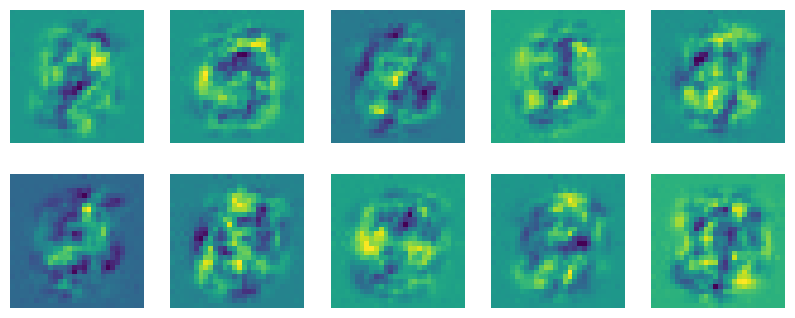

In [9]:
# mnist noise examples
noise = np.load('cache/gabor_noise.npy')
figure(num=None, figsize=(10, 4), dpi=100, facecolor='w', edgecolor='k')
for i in range(10):
    a = noise[i]
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(a)
plt.show()

## (common part) pass noise through CNN model

In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x1 = F.relu(self.conv1(x))
        x = F.max_pool2d(x1, 2, 2)
        x2 = F.relu(self.conv2(x))
        x = F.max_pool2d(x2, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x, x2, x1
    
model = Model()
if cuda:
    model.cuda() # CUDA!
# optimizer = optim.Adam(model.parameters(), lr=1e-3) 
# Load and use the best model
bst_mdl = 'cache/models/MNIST_epoch_12.pth'
model.load_state_dict(torch.load(bst_mdl)['model'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [5]:
noise = np.load('cache/gabor_noise.npy')
num_noise = noise.shape[0]
num_cls = 10

noise_data = {}
for cls in range(num_cls):
    noise_data[cls] = []

batch_size = 10000
model.eval()
with tqdm(total=num_noise//batch_size, file=sys.stdout) as pbar:
    for i in range(num_noise//batch_size):
        data = torch.from_numpy(noise[i * batch_size: (i+1) * batch_size]).float()
        if cuda:
            data = data.cuda()
        with torch.no_grad():
            pred = model(data[:,None,...])[0].max(1)[1]
            for cls in range(num_cls):
                noise_data[cls].append(data[pred==cls].cpu())
        pbar.update(1)

for cls in range(num_cls):
    noise_data[cls] = torch.cat(noise_data[cls])
    print(cls, ':', noise_data[cls].shape[0])

100%|██████████| 100/100 [00:02<00:00, 37.90it/s]
0 : 91646
1 : 2436
2 : 108908
3 : 168554
4 : 126963
5 : 73669
6 : 18064
7 : 94379
8 : 270481
9 : 44900


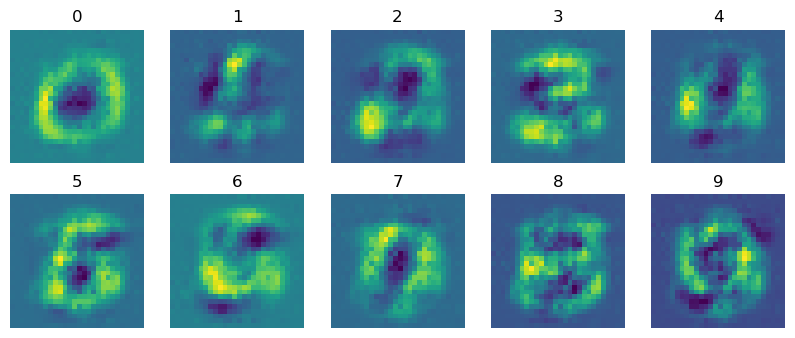

In [6]:
noise_avg = []
figure(num=None, figsize=(10, 4), dpi=100, facecolor='w', edgecolor='k')
for cls in range(num_cls):
#     a = noise_data[cls].mean(0).numpy()
    a = torch.sqrt((noise_data[cls]**2).mean(0)).numpy()
    a = (a - a.min()) / (a.max() - a.min())
    noise_avg.append(a)
    plt.subplot(2, 5, cls+1)
    plt.axis('off')
    plt.title(str(cls))
    plt.imshow(a)
plt.show()

In [7]:
def plot_confusion_matrix( y_pred, y_true, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  
    import sklearn
    from sklearn import metrics
#     cf = sklearn.metrics.confusion_matrix(pred.numpy(), gt.numpy())  
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
  
    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_pred, y_true)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] )
#         print("Normalized confusion matrix")
    else:
        pass
#         print('Confusion matrix, without normalization')
#     print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]+1)-0.5,
           yticks=np.arange(cm.shape[0]+1)-0.5,
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Predicted label',
           xlabel='True label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# # Plot non-normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names,
#                       title='Confusion matrix, without normalization')
# # Plot normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')
# plt.show()

(10, 784)
Accuracy:  0.3555


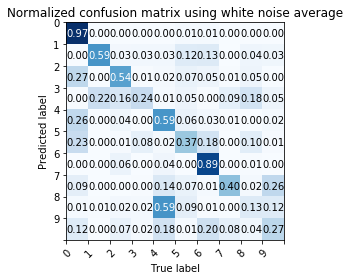

In [16]:
##### Dot product NN #####

avg_vec = np.stack(noise_avg).reshape(num_cls, -1)
print(avg_vec.shape)

pred = []
gt = []
templates = torch.from_numpy(avg_vec).permute(1, 0)
templates = templates / torch.norm(templates, p=2, dim=0)

data = test.test_data.float()
gt = test.test_labels
x = data.view(data.shape[0], -1)
x = x / torch.cat([torch.norm(x, p=2, dim=1).view(-1,1)] * x.shape[1], 1)
pred = torch.mm(x, templates).max(1)[1]

acc = (pred==gt).sum().type(dtype=torch.float64) / len(gt)
print('Accuracy: ', acc.numpy())
plot_confusion_matrix(pred.numpy(), gt.numpy(), classes=list(range(10)), normalize=True,  title='Normalized confusion matrix using white noise average')

In [9]:
test.test_labels.shape

torch.Size([10000])

### CIFAR-10

In [19]:
# Create DataLoader
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
transform = transforms.ToTensor()

train = CIFAR10('./data', train=True, download=True, transform=transform)
test = CIFAR10('./data', train=False, download=True, transform=transform)

dataloader_args = dict(batch_size=256,num_workers=4, 
                       pin_memory=True) if cuda else dict(batch_size=64)
train_loader = dataloader.DataLoader(train, shuffle=True, **dataloader_args)
test_loader = dataloader.DataLoader(test, shuffle=False, **dataloader_args)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_cls = len(classes)
p = train.train_data.shape[1]
print('class number: {}'.format(num_cls))
print('image size: {}'.format(p))

Files already downloaded and verified
Files already downloaded and verified
class number: 10
image size: 32


In [20]:
len(train.train_data)

50000

In [40]:
# generate gabor filters ==> each channel has these many

n_theta = 4
n_psi = 2
Theta = [i * np.pi /n_theta for i in range(n_theta)]
Psi = [i * np.pi /n_psi for i in range(n_psi)]
ksize = [3, 5, 9, 17]
# ksize = [5, 15, 29]
rep_ct = [int(ceil(p/i)) for i in ksize]
print('\n', Theta, '\n', Psi, '\n', rep_ct)

g_kernels = []
for i in range(len(rep_ct)):
    for _theta in Theta:
        for _psi in Psi:
            for rep in range(rep_ct[i]**2):
                k = ksize[i]
                g_kernel = cv2.getGaborKernel((k, k), k/7.0, _theta, k/2.0,
                                              0.5, _psi, ktype=cv2.CV_32F) 
                g_kernel = (g_kernel - g_kernel.min())/(g_kernel.max()-g_kernel.min())
                g_kernels.append(g_kernel)
                
print(len(g_kernels))

img_kernels = []
ctr = 0
for idx in range(len(rep_ct)):
    cur_ct = rep_ct[idx]
    k = ksize[idx]
    print(ctr, cur_ct, k)
    for _ in range(n_theta * n_psi):
        with tqdm(total=cur_ct**2, file=sys.stdout) as pbar:
            for i in range(cur_ct):
                for j in range(cur_ct):
#                     import pdb;pdb.set_trace()
                    tmp = np.zeros((p, p))
                    size_i = min(k*(i+1), p) - k*i
                    size_j = min(k*(j+1), p) - k*j
                    tmp[k*i: k*i + size_i, k*j: k*j + size_j] = g_kernels[ctr][:size_i, :size_j]
                    img_kernels.append(tmp)
                    ctr += 1
                    pbar.update(1)


 [0.0, 0.7853981633974483, 1.5707963267948966, 2.356194490192345] 
 [0.0, 1.5707963267948966] 
 [11, 7, 4, 2]
1520
0 11 3
100%|██████████| 121/121 [00:00<00:00, 82575.79it/s]
968 7 5
100%|██████████| 49/49 [00:00<00:00, 53423.68it/s]
1360 4 9
100%|██████████| 16/16 [00:00<00:00, 23730.15it/s]
1488 2 17
100%|██████████| 4/4 [00:00<00:00, 7013.89it/s]


### Greyscale

In [15]:
# ridge regression to get weights (on greyscale images)

num_sample = len(train.train_data)
X = np.stack(img_kernels, -1)
X = X.reshape(-1, X.shape[-1])

y = train.train_data[:num_sample].mean(-1).transpose(1, 2, 0)/255.0
y = y.reshape(-1, y.shape[-1])

print(X.shape, y.shape)

clf = Ridge(alpha=0.1)
clf.fit(X, y)

wts = clf.coef_
print(wts.shape)
np.save('cache/cifar_gabor_wts.npy', wts)

(1024, 1520) (1024, 50000)
(50000, 1520)


(32, 32)
rec 0.0 1.0


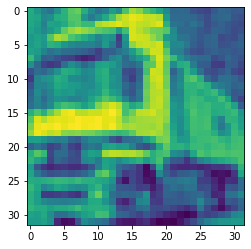

ori 0.02875816993464052 0.9934640522875817


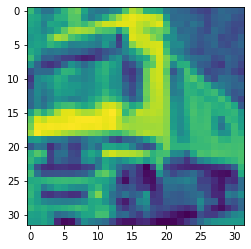

0.6723976766639843


In [20]:
# reconstruction visualization (grey scale)
img_id = 1

rec = wts.dot(X.T)[img_id].reshape(p, p)
rec = (rec-rec.min())/(rec.max()-rec.min())

print(rec.shape)
print('rec', rec.min(), rec.max())
plt.imshow(rec)
plt.show()

ori = train.train_data[img_id].mean(-1)/255.0
print('ori', ori.min(), ori.max())
plt.imshow(ori)
plt.show()

print(np.linalg.norm(ori - rec))

In [21]:
# PCA (greyscale)
all_wts = np.load('cache/cifar_gabor_wts.npy')
from sklearn.decomposition import PCA
num_pc = 600
pca = PCA(n_components=num_pc)
principalComponents = pca.fit_transform(all_wts)
print(pca.explained_variance_ratio_.sum())
print(principalComponents.shape)
print(pca.components_.shape)

0.9747512940677767
(50000, 600)
(600, 1520)


In [22]:
num_noise = 1000000
noise_wts = np.random.rand(num_noise, num_pc)

with tqdm(total=num_pc, file=sys.stdout) as pbar:
    for i in range(num_pc):
        cur_max = principalComponents[:, i].max()
        cur_min = principalComponents[:, i].min()
        cur_wts = noise_wts[:, i]
        cur_wts = (cur_wts - cur_wts.min())/(cur_wts.max() - cur_wts.min())
        noise_wts[:, i] = cur_wts * (cur_max - cur_min) + cur_min
    
        pbar.update(1)

noise_gabor_wts = noise_wts.dot(pca.components_)
noise_gabor_wts.shape

100%|██████████| 600/600 [00:46<00:00, 13.03it/s]


(1000000, 1520)

In [23]:
X = np.stack(img_kernels)
X = X.reshape(X.shape[0], -1)
noise = noise_gabor_wts.dot(X).reshape(num_noise, p, p)
print(noise.shape)
with tqdm(total=num_noise, file=sys.stdout) as pbar:
    for i in range(num_noise):
        noise[i] = (noise[i] - noise[i].min())/(noise[i].max() - noise[i].min())
        pbar.update(1)
np.save('cache/cifar_gabor_noise.npy', noise)

(1000000, 32, 32)


### 3-channel

In [43]:
# ridge regression to get weights ==> separate regression for each channel
all_wts = {}
num_sample = len(train.train_data)
X = np.stack(img_kernels, -1)
X = X.reshape(-1, X.shape[-1])
Y_ = train.train_data[:num_sample]/255.0
print(X.shape, Y_.shape)

for channel in range(3):
    y = Y_[:, :, :, channel].transpose(1, 2, 0)
    y = y.reshape(-1, y.shape[-1])
    print(y.shape)
    
    clf = Ridge(alpha=0.1)
    clf.fit(X, y)

    wts = clf.coef_
    print(wts.shape)
    all_wts[channel] = wts
    

(1024, 1520) (50000, 32, 32, 3)
(1024, 50000)
(50000, 1520)
(1024, 50000)
(50000, 1520)
(1024, 50000)
(50000, 1520)


channel 0
(32, 32)
rec 0.0 1.0
ori 0.0196078431372549 0.996078431372549


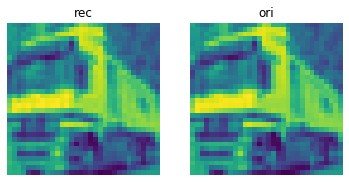

channel 1
(32, 32)
rec 0.0 1.0
ori 0.023529411764705882 0.9921568627450981


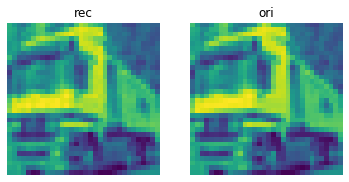

channel 2
(32, 32)
rec 0.0 1.0
ori 0.027450980392156862 0.996078431372549


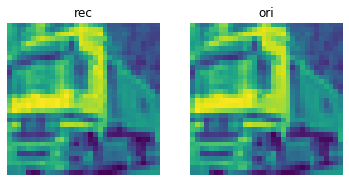

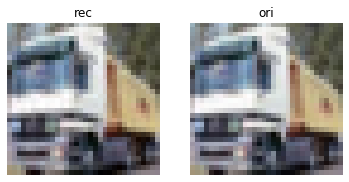

1.1548832341506012


In [48]:
# reconstruction visualization 
img_id = 1
rec_ = []
for channel in range(3):
    print('channel', channel)
    wts = all_wts[channel]
    rec = wts.dot(X.T)[img_id].reshape(p, p)
    rec = (rec-rec.min())/(rec.max()-rec.min())

    print(rec.shape)
    print('rec', rec.min(), rec.max())
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title('rec')
    plt.imshow(rec)

    ori = Y_[img_id, :, :, channel]
    print('ori', ori.min(), ori.max())
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.title('ori')
    plt.imshow(ori)
    plt.show()
    
    rec_.append(rec)

rec_ = np.stack(rec_, -1)
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('rec')
plt.imshow(rec_)
plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('ori')
plt.imshow(Y_[img_id])
plt.show()
print(np.linalg.norm(Y_[img_id] - rec_))

In [49]:
# PCA, per channel
from sklearn.decomposition import PCA
num_pc = 600

all_pc_wts = []
all_pc = []
for channel in range(3):
    pca = PCA(n_components=num_pc)
    pc_wts = pca.fit_transform(all_wts[channel])

    print(pca.explained_variance_ratio_.sum())
    all_pc_wts.append(pc_wts)
    print(pc_wts.shape)
    all_pc.append(pca.components_)
    print(pca.components_.shape)

0.9757347681628861
(50000, 600)
(600, 1520)
0.9750842718859883
(50000, 600)
(600, 1520)
0.9751633457320403
(50000, 600)
(600, 1520)


In [51]:
all_pc_wts[0].shape

(50000, 600)

In [52]:
# generate random pc weights
num_noise = 1000000

all_noise_gabor_wts = []
for channel in range(3):
    pc_wts = all_pc_wts[channel]
    pc = all_pc[channel]
    noise_wts = np.random.rand(num_noise, num_pc)
    with tqdm(total=num_pc, file=sys.stdout) as pbar:
        for i in range(num_pc):
            cur_max = pc_wts[:, i].max()
            cur_min = pc_wts[:, i].min()
            cur_wts = noise_wts[:, i]
            cur_wts = (cur_wts - cur_wts.min())/(cur_wts.max() - cur_wts.min())
            noise_wts[:, i] = cur_wts * (cur_max - cur_min) + cur_min

            pbar.update(1)
    noise_gabor_wts = noise_wts.dot(pc)
    print(noise_gabor_wts.shape)
    all_noise_gabor_wts.append(noise_gabor_wts)

100%|██████████| 600/600 [00:46<00:00, 12.86it/s]
(1000000, 1520)
100%|██████████| 600/600 [00:46<00:00, 12.98it/s]
(1000000, 1520)
100%|██████████| 600/600 [00:46<00:00, 12.96it/s]
(1000000, 1520)


In [55]:
np.save('cache/cifar_noise_gabor_wts_color.npy', np.stack(all_noise_gabor_wts))

In [56]:
# noise generation
X = np.stack(img_kernels)
X = X.reshape(X.shape[0], -1)

all_noise = []
for channel in range(3):
    noise_gabor_wts = all_noise_gabor_wts[channel]
    noise = noise_gabor_wts.dot(X).reshape(num_noise, p, p)
    print(noise.shape)
    with tqdm(total=num_noise, file=sys.stdout) as pbar:
        for i in range(num_noise):
            noise[i] = (noise[i] - noise[i].min())/(noise[i].max() - noise[i].min())
            pbar.update(1)
    all_noise.append(noise)
all_noise = np.stack(all_noise, -1)
print(all_noise.shape)
np.save('cache/cifar_gabor_noise_color.npy', all_noise)

(1000000, 32, 32)
100%|██████████| 1000000/1000000 [00:11<00:00, 90519.32it/s]
(1000000, 32, 32)
100%|██████████| 1000000/1000000 [00:11<00:00, 90036.95it/s]
(1000000, 32, 32)
100%|██████████| 1000000/1000000 [00:11<00:00, 90040.27it/s]
(1000000, 32, 32, 3)


### ----------------------------- PASS NOISE TO MODEL -----------------------------

In [4]:
class Model(nn.Module):
    def __init__(self, p):
        super(Model, self).__init__()

        self.conv1 = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=3, out_channels=p, kernel_size=3, padding=1),
            nn.BatchNorm2d(p),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=p, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Sequential(
            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool2 = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05)
        )

        self.conv3 = nn.Sequential(
            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc_layer1 = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True)
        )
        self.fc_layer2 = nn.Sequential(
            nn.Dropout(p=0.1),
            nn.Linear(512, 10)
        )


    def forward(self, x):
        """Perform forward."""
        
        # conv layers
        x_conv1 = self.conv1(x)
        x_conv2 = self.conv2(self.pool1(x_conv1))
        x_conv3 = self.conv3(self.pool2(x_conv2))
        x1 = self.pool3(x_conv3)
        
        # flatten
        x2 = x1.view(x1.size(0), -1)
        
        # fc layer
        x3 = self.fc_layer1(x2)
        x4 = self.fc_layer2(x3)

        return x4, x3, x_conv3, x_conv2, x_conv1
      
model = Model(p)
if cuda:
    model.cuda() # CUDA!
    
bst_mdl = 'cache/models/best_drop.pth'
model.load_state_dict(torch.load(bst_mdl)['model'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [31]:
# greyscale
noise = np.load('cache/cifar_gabor_noise.npy')
num_noise = noise.shape[0]

noise_data = {}
for cls in range(num_cls):
    noise_data[cls] = []

batch_size = 10000
model.eval()
with tqdm(total=num_noise//batch_size, file=sys.stdout) as pbar:
    for i in range(num_noise//batch_size):
        data = torch.from_numpy(noise[i * batch_size: (i+1) * batch_size]).float()
        if cuda:
            data = data.cuda()
        with torch.no_grad():
            pred = model(data[:,None,...].expand(-1, 3, -1, -1))[0].max(1)[1]
            for cls in range(num_cls):
                noise_data[cls].append(data[pred==cls].cpu())
        pbar.update(1)

for cls in range(num_cls):
    noise_data[cls] = torch.cat(noise_data[cls])
    print(classes[cls], ':', noise_data[cls].shape[0])

100%|██████████| 100/100 [00:32<00:00,  3.13it/s]
plane : 6226
car : 208
bird : 35573
cat : 543216
deer : 109014
dog : 18254
frog : 244093
horse : 4225
ship : 19938
truck : 19253


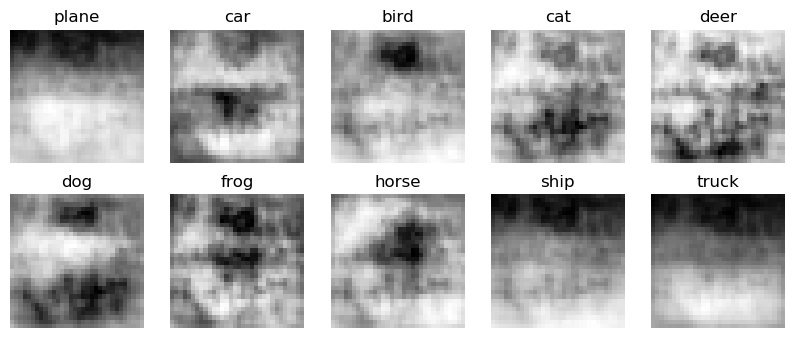

In [32]:
# greyscale noise mean
noise_avg = []
figure(num=None, figsize=(10, 4), dpi=100, facecolor='w', edgecolor='k')
for cls in range(num_cls):
    a = noise_data[cls].mean(0).numpy()
    a = (a - a.min()) / (a.max() - a.min())
    noise_avg.append(a)
    plt.subplot(2, 5, cls+1)
    plt.axis('off')
    plt.title(f'{classes[cls]}')
    plt.imshow(a, cmap='Greys')
plt.show()

In [5]:
# colored
noise = np.load('cache/cifar_gabor_noise_color.npy')
num_noise = noise.shape[0]

noise_data = {}
for cls in range(num_cls):
    noise_data[cls] = []

batch_size = 10000
model.eval()
with tqdm(total=num_noise//batch_size, file=sys.stdout) as pbar:
    for i in range(num_noise//batch_size):
        data = torch.from_numpy(noise[i * batch_size: (i+1) * batch_size]).float()
        if cuda:
            data = data.cuda()
        with torch.no_grad():
            pred = model(data.permute(0, 3, 1, 2))[0].max(1)[1]
            for cls in range(num_cls):
                noise_data[cls].append(data[pred==cls].cpu())
        pbar.update(1)

for cls in range(num_cls):
    noise_data[cls] = torch.cat(noise_data[cls])
    print(classes[cls], ':', noise_data[cls].shape[0])

100%|██████████| 100/100 [00:38<00:00,  2.64it/s]
plane : 72859
car : 16816
bird : 152686
cat : 194493
deer : 85048
dog : 98723
frog : 261067
horse : 16355
ship : 26550
truck : 75403


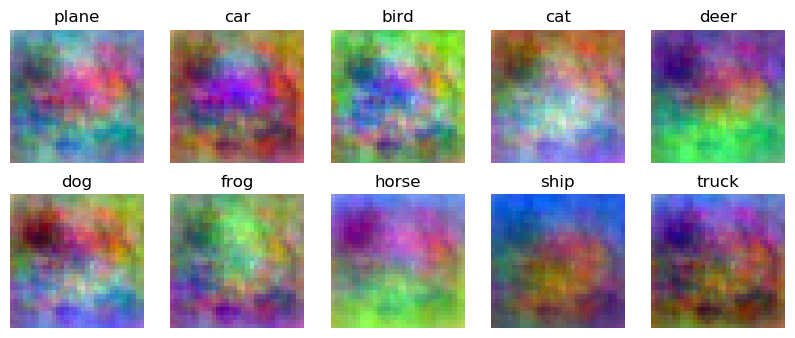

In [49]:
# colored noise mean
noise_avg = []
figure(num=None, figsize=(10, 4), dpi=100, facecolor='w', edgecolor='k')
for cls in range(num_cls):
#     a = noise_data[cls].mean(0).numpy()
    a = torch.sqrt((noise_data[cls]**2).mean(0)).numpy()
    a = (a - a.min()) / (a.max() - a.min())
    noise_avg.append(a)
    plt.subplot(2, 5, cls+1)
    plt.axis('off')
    plt.title(f'{classes[cls]}')
    plt.imshow(a, cmap='jet')
plt.show()

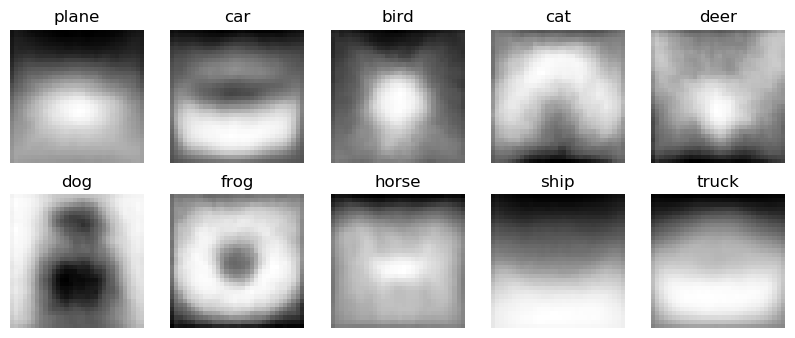

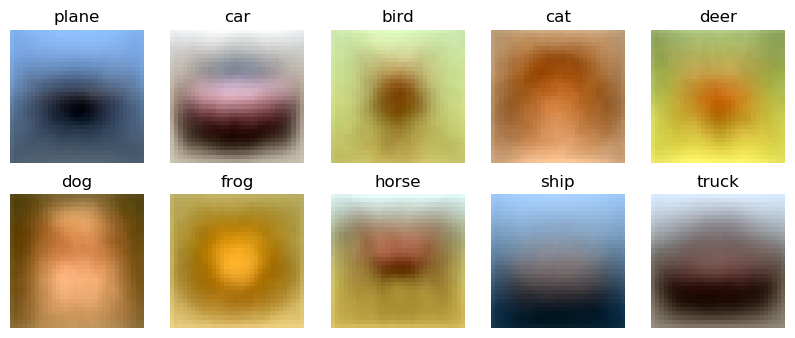

In [37]:
###### plot data mean #####
stats = {}
for i in range(num_cls):
    stats[i] = 0
    
# all training images
avgs = torch.zeros(len(train_loader), num_cls, 3, p, p)
for batch_idx, (data, target) in enumerate(train_loader):
    for i in range(num_cls):
        subdata = data[target == i]
        avgs[batch_idx, i] = torch.sqrt((subdata**2).mean(0))
#         avgs[batch_idx, i] = subdata.mean(0)
        stats[i] += subdata.shape[0]
# # 1 batch
# avgs = torch.zeros(1, num_cls, 3, p, p)
# data, target = next(iter(train_loader))
# for i in range(num_cls):
#     subdata = data[target == i]
#     avgs[0, i] = torch.sqrt((subdata**2).mean(0))
#     stats[i] += subdata.shape[0]

data_avg = torch.mean(avgs, dim=0)

figure(num=None, figsize=(10, 4), dpi=100, facecolor='w', edgecolor='k')
for i in range(num_cls):
    a = data_avg[i]
    a = (a - a.min()) / (a.max() - a.min())
    pred = model(a[None,...].cuda())[0].max(1)[1]
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.title(f'{classes[i]}')
    plt.imshow(a.permute(1,2,0).mean(-1), cmap='Greys')
plt.show()


figure(num=None, figsize=(10, 4), dpi=100, facecolor='w', edgecolor='k')
for i in range(num_cls):
    a = data_avg[i]
    a = (a - a.min()) / (a.max() - a.min())
    pred = model(a[None,...].cuda())[0].max(1)[1]
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.title(f'{classes[i]}')
    plt.imshow(a.permute(1,2,0), cmap='jet')
plt.show()

In [13]:
def plot_confusion_matrix( y_pred, y_true, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
  
    import sklearn
    from sklearn import metrics
#     cf = sklearn.metrics.confusion_matrix(pred.numpy(), gt.numpy())  
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
  
    # Compute confusion matrix
    cm = sklearn.metrics.confusion_matrix(y_pred, y_true)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] )
#         print("Normalized confusion matrix")
    else:
        pass
#         print('Confusion matrix, without normalization')
#     print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]+1)-0.5,
           yticks=np.arange(cm.shape[0]+1)-0.5,
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Predicted label',
           xlabel='True label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# # Plot non-normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names,
#                       title='Confusion matrix, without normalization')
# # Plot normalized confusion matrix
# plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
#                       title='Normalized confusion matrix')
# plt.show()

(10, 3072)
Accuracy:  0.2167


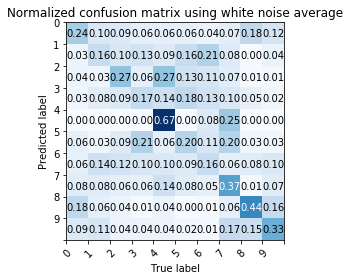

In [50]:
##### Dot product NN #####

# avg_vec = np.stack(noise_avg).reshape(num_cls, -1)
avg_vec = np.stack(noise_avg).transpose(0, 3, 1, 2).reshape(num_cls, -1)
# avg_vec = data_avg.mean(1).reshape(num_cls, -1).numpy()
# avg_vec = data_avg.reshape(num_cls, -1).numpy()
print(avg_vec.shape)

pred = []
gt = []
templates = torch.from_numpy(avg_vec).permute(1, 0)
templates = templates / torch.norm(templates, p=2, dim=0)

for batch_idx, (data, target) in enumerate(test_loader):
#     data = data.mean(1) # for greyscale
    x = data.view(data.shape[0], -1)
    x = x / torch.cat([torch.norm(x, p=2, dim=1).view(-1,1)] * x.shape[1], 1)
    pred.append(torch.mm(x, templates).max(1)[1])
    gt.append(target)
pred = torch.cat(pred)
gt = torch.cat(gt)

acc = (pred==gt).sum().type(dtype=torch.float64) / len(gt)
print('Accuracy: ', acc.numpy())
plot_confusion_matrix(pred.numpy(), gt.numpy(), classes=list(range(10)), normalize=True,  title='Normalized confusion matrix using white noise average')

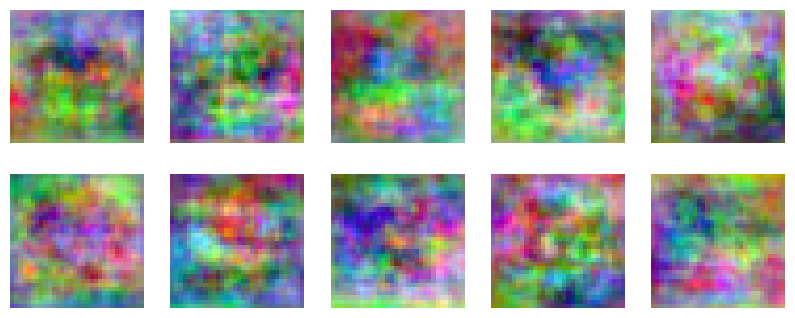

In [53]:
# cifar colored noise examples
figure(num=None, figsize=(10, 4), dpi=100, facecolor='w', edgecolor='k')
for i in range(10):
    a = noise[i]
    a = (a - a.min()) / (a.max() - a.min())
    plt.subplot(2, 5, i+1)
    plt.axis('off')
    plt.imshow(a, cmap='jet')
plt.show()